## <font color=blue>Jupyter Setup<font/>

###  Import required libraries:

In [1]:
# surprise libraries
from surprise import Dataset, dataset, Reader
from surprise.model_selection import train_test_split
from surprise.dataset import DatasetAutoFolds
from surprise.trainset import Trainset

In [2]:
#general libraries
import pandas as pd
import numpy as np
import math
from datetime import date, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline

In [3]:
pd.set_option('display.max_columns', 600)

**<font color=black>----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------<font>**

## <font color=blue>Data Load<font/>

### Load data:

In [4]:
ratings = pd.read_csv('/Users/flatiron/Downloads/ml-latest-small/' + 'ratings.csv')

movies = pd.read_csv('/Users/flatiron/Downloads/ml-latest-small/' + 'movies.csv')

links = pd.read_csv('/Users/flatiron/Downloads/ml-latest-small/' + 'links.csv')

tags = pd.read_csv('/Users/flatiron/Downloads/ml-latest-small/' + 'tags.csv')

**<font color=black>-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------<font>**

### Preview data:

In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [8]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


**<font color=black>----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------<font>**

## <font color=blue>Exploratory Data Analysis</font>

## Ratings data

### Identify variables and variable Types:

In [9]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
userId       100836 non-null int64
movieId      100836 non-null int64
rating       100836 non-null float64
timestamp    100836 non-null int64
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


**<font color=black>-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------<font>**

### Count users, movies and ratings within the utility matrix:

In [10]:
print('number of movies rated:', ratings.movieId.nunique())

number of movies rated: 9724


In [11]:
print('number of users who rated:', ratings.userId.nunique())

number of users who rated: 610


**A total of 100,836 ratings, made by 610 users of 9,724 movies**

In [12]:
ratings_clean = ratings.drop('timestamp', axis = 1)

In [35]:
ratings_count = pd.DataFrame(ratings_clean.groupby('movieId').count() \
                             ['rating']).reset_index().rename(columns={"rating": "ratings_count"})

ratings_count['ratings_count_rank'] = ratings_count['ratings_count'].rank(method = 'max', ascending = False)

ratings_count = ratings_count.sort_values(by=['ratings_count'], ascending = False).reset_index(drop=True)

In [51]:
ratings_count.ratings_count.describe()

count    9724.000000
mean       10.369807
std        22.401005
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       329.000000
Name: ratings_count, dtype: float64

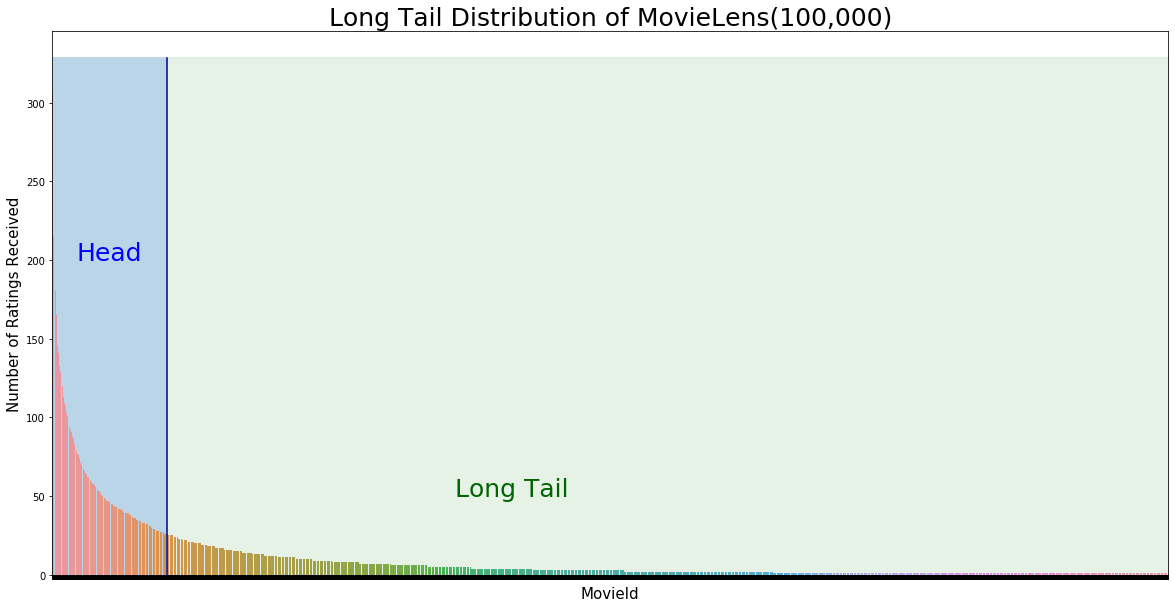

In [119]:
fig2, ax = plt.subplots(figsize = (20,10))
ax.fill_between(np.linspace(0, 1000, 1000), 329, alpha = 0.3)
ax.fill_between(np.linspace(1000, 9732, 1000), 329, alpha = 0.1, color = 'green')
ax = sns.barplot(x = ratings_count.index, y = 'ratings_count', data = ratings_count, ci = None)
ax.set_xlabel('MovieId', fontsize = 15)
ax.set_ylabel('Number of Ratings Received', fontsize = 15)
ax.annotate('Head', # this is the text
                (500,200), # this is the point to label
                textcoords="offset points", # how to position the text
                xytext=(0,0), # distance from text to points (x,y)
                ha='center',
                fontsize = 25,
                color = 'blue')
ax.annotate('Long Tail', # this is the text
                (4000,50), # this is the point to label
                textcoords="offset points", # how to position the text
                xytext=(0,0), # distance from text to points (x,y)
                ha='center',
                fontsize = 25,
                color = 'darkgreen')
ax.set_xticklabels([])
ax.axvline(1000, 0, 0.95, color = 'darkblue')
ax.set_title('Long Tail Distribution of MovieLens(100,000)', fontsize = 25);

<font size="4">Over 75% of movies have received fewer than 10 reviews, with +50% having only received 3 or fewer reviews. This is depicted in the above bar plot where the 'long tail' constitutes approximately 10% of all movies that have been rated at least once.<br><br>For the purpose of this analysis it will be assumed that the number of ratings is indicative of how many people watched the movie.<font>

**<font color=black>-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------<font>**

### Average rating score:

In [12]:
ratings.rating.describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [13]:
ratings.rating.median()

3.5

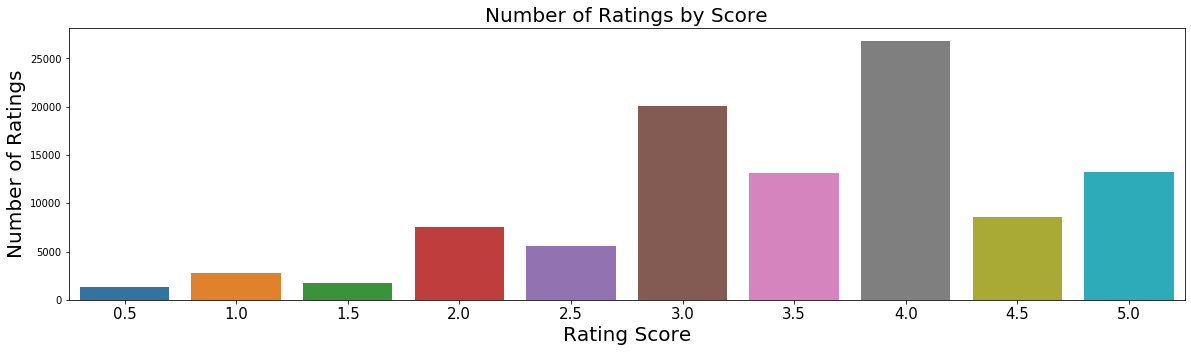

In [121]:
fig2, ax = plt.subplots(figsize = (20,5))
sns.countplot(x = 'rating', data = ratings, ax = ax)
ax.set_xlabel('Rating Score', fontsize = 20)
ax.set_ylabel('Number of Ratings', fontsize = 20)
ax.set_xticklabels(np.linspace(0.5, 5, 10), fontsize = 15)
ax.set_title('Number of Ratings by Score', fontsize = 20);

<font size="4">The mean and median rating score is 3.5 <br/>
Users show a greater affinity to scoring higher than lower.<font>

In [55]:
ratings_count['rc_bin'] = pd.cut(ratings_count['ratings_count'], bins=10)

In [68]:
median_ratings_by_bin = ratings.merge(ratings_count.loc[:,['movieId','rc_bin']], how = 'left', \
                                      on = 'movieId').groupby('rc_bin').median()['rating']

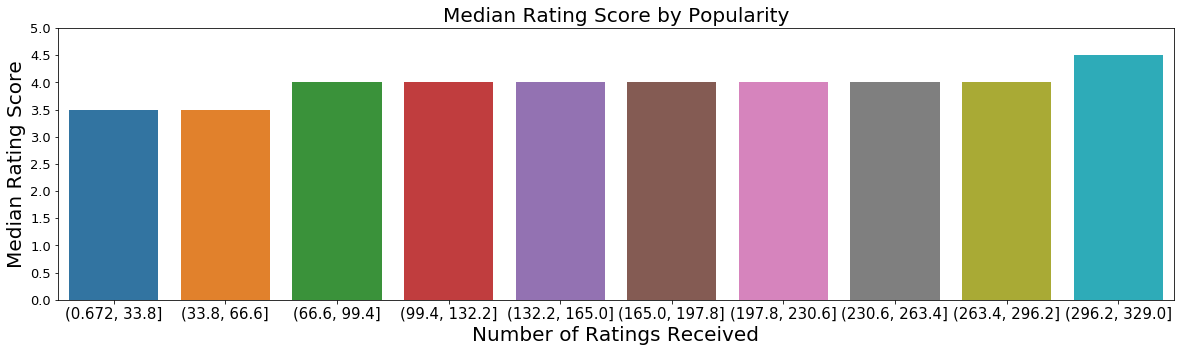

In [123]:
fig2, ax = plt.subplots(figsize = (20,5))
sns.barplot(x = median_ratings_by_bin.index, y = median_ratings_by_bin, ax = ax)
ax.set_ylim(0,5)
ax.set_yticks(np.linspace(0, 5, 11))
ax.set_xlabel('Number of Ratings Received', fontsize = 20)
ax.set_ylabel('Median Rating Score', fontsize = 20)
ax.set_xticklabels(median_ratings_by_bin.index, fontsize = 15)
ax.set_yticklabels(np.linspace(0, 5, 11), fontsize = 13)
ax.set_title('Median Rating Score by Popularity', fontsize = 20);

<font size="4">Even when we group the movies by how many ratings they recieved. All groups recieved a median of +3.5 points again indicating users' a greater affinity to scoring higher rather than lower.<font>

**<font color=black>-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------<font>**

## Movies data

### Identify variables and variable Types:

In [16]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
movieId    9742 non-null int64
title      9742 non-null object
genres     9742 non-null object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [17]:
print('Number of movies in database:',movies.movieId.nunique())

Number of movies in database: 9742


In [18]:
print('Number of genre combinations:',movies.genres.nunique())

Number of genre combinations: 951


In [19]:
distinct_genres = set()
for genre in list(movies.genres.unique()):
    distinct_genres.update(genre.lower().split('|'))

print('distinct genres:\n', list(distinct_genres),'\n')
print('numnber distinct genres:', len(distinct_genres)-1)

distinct genres:
 ['thriller', 'comedy', 'mystery', 'film-noir', 'horror', 'romance', 'action', 'documentary', 'imax', 'adventure', 'musical', '(no genres listed)', 'western', 'war', 'drama', 'animation', 'sci-fi', 'fantasy', 'children', 'crime'] 

numnber distinct genres: 19


**A total of 9,742 movies in the database, classified by different combinations from 19 genre labels**

**<font color=black>-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------<font>**

## Tags data

### Identify variables and variable Types:

In [20]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
userId       3683 non-null int64
movieId      3683 non-null int64
tag          3683 non-null object
timestamp    3683 non-null int64
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


In [21]:
print('Number of tagged movies:',tags.movieId.nunique())

Number of tagged movies: 1572


In [22]:
print('Number of users who tagged:',tags.userId.nunique())

Number of users who tagged: 58


**A total of 58 users tagged 1,572 movies**

**<font color=black>----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------<font>**